# Gaming Data Lab — Steam (ARPG focus)

**Datasets used:**  
- `steam.csv` — core metadata (name, release date, genres, price, reviews, etc.)  
- `steamspy_tag_data.csv` — SteamSpy tag coverage per game (wide format)

**Why this dataset?**  
I love ARPGs, so I’m analyzing how ARPGs compare to the broader Steam catalog (prevalence, pricing, reviews, release trends, and common co-tags).

**What this notebook does:**  
1. Loads + lightly cleans Steam + SteamSpy CSVs  
2. Defines an ARPG flag (via “Action RPG” tag or “Action”+“RPG” in genres)  
3. Answers 5 questions with Pandas, each with a brief written answer


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Markdown, display

def say(md: str):
    """Render a Markdown string from a code cell."""
    display(Markdown(md))

def fmt_money(x):
    import pandas as pd
    import numpy as np
    if x is None or (isinstance(x, float) and (pd.isna(x) or np.isnan(x))):
        return "N/A"
    return f"${x:,.2f}"

# Paths 
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA = ROOT / "data"
OUT  = ROOT / "reports"
OUT.mkdir(exist_ok=True, parents=True)

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)


In [2]:
steam = pd.read_csv(DATA / "steam.csv")
tags  = pd.read_csv(DATA / "steamspy_tag_data.csv")

steam.head(), tags.head()


(   appid                       name release_date  english         developer  \
 0     10             Counter-Strike   2000-11-01        1             Valve   
 1     20      Team Fortress Classic   1999-04-01        1             Valve   
 2     30              Day of Defeat   2003-05-01        1             Valve   
 3     40         Deathmatch Classic   2001-06-01        1             Valve   
 4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   
 
   publisher          platforms  required_age  \
 0     Valve  windows;mac;linux             0   
 1     Valve  windows;mac;linux             0   
 2     Valve  windows;mac;linux             0   
 3     Valve  windows;mac;linux             0   
 4     Valve  windows;mac;linux             0   
 
                                           categories  genres  \
 0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
 1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
 2              Multi-playe

## Dataset Summary

- **steam.csv** includes fields such as:
  - `appid`, `name`, `release_date`, `genres`, `steamspy_tags`, `publisher`, `developer`
  - `price`, `positive_ratings`, `negative_ratings`, `owners` (range), `average_playtime`, `median_playtime`
- **steamspy_tag_data.csv**: one row per `appid`, with many tag columns holding percentage coverage for that tag.

**Why it’s interesting:**  
This data lets me focus specifically on **Action RPGs (ARPGs)** versus other Steam titles — comparing prevalence, pricing, player review signals, year-over-year release trends, and common co-tags that characterize the ARPG space.


In [3]:
# standardize column names
steam.columns = [c.lower() for c in steam.columns]
tags.columns  = [c.lower()  for c in tags.columns]

# keep a useful subset if present
keep = [
    "appid","name","release_date","english","developer","publisher",
    "platforms","required_age","categories","genres","steamspy_tags",
    "achievements","positive_ratings","negative_ratings","average_playtime",
    "median_playtime","owners","price"
]
steam = steam[[c for c in keep if c in steam.columns]].copy()

# release year
steam["release_year"] = pd.to_datetime(steam["release_date"], errors="coerce").dt.year

# total reviews
steam["positive_ratings"] = pd.to_numeric(steam["positive_ratings"], errors="coerce").fillna(0)
steam["negative_ratings"] = pd.to_numeric(steam["negative_ratings"], errors="coerce").fillna(0)
steam["reviews_total"] = steam["positive_ratings"] + steam["negative_ratings"]

# ARPG flag:
#   True if "Action RPG" appears in steamspy_tags
#   Or if genres contains both "Action" and "RPG"
def is_arpg_row(row):
    g  = (row.get("genres") or "").lower()
    st = (row.get("steamspy_tags") or "").lower()
    return ("action rpg" in st) or ("action" in g and "rpg" in g)

steam["is_arpg"] = steam.apply(is_arpg_row, axis=1)

# reshape steamspy_tag_data to long form:
# resulting columns: appid, tag, pct
tag_long = (
    tags
    .set_index("appid")
    .stack()
    .reset_index(name="pct")         # value column named "pct"
    .rename(columns={"level_1": "tag"})
)

# keep only positive% tags
tag_long = tag_long[tag_long["pct"] > 0]

steam.head(3), tag_long.head(3)


(   appid                   name release_date  english developer publisher  \
 0     10         Counter-Strike   2000-11-01        1     Valve     Valve   
 1     20  Team Fortress Classic   1999-04-01        1     Valve     Valve   
 2     30          Day of Defeat   2003-05-01        1     Valve     Valve   
 
            platforms  required_age  \
 0  windows;mac;linux             0   
 1  windows;mac;linux             0   
 2  windows;mac;linux             0   
 
                                           categories  genres  \
 0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
 1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
 2              Multi-player;Valve Anti-Cheat enabled  Action   
 
                   steamspy_tags  achievements  positive_ratings  \
 0        Action;FPS;Multiplayer             0            124534   
 1        Action;FPS;Multiplayer             0              3318   
 2  FPS;World War II;Multiplayer             0              34

## Q1. How common are ARPGs on Steam?
We estimate ARPG status using tags/genres. What fraction of Steam titles are ARPGs?

In [4]:
total_games = len(steam)
arpg_games  = int(steam["is_arpg"].sum())
pct_arpg    = (arpg_games / total_games * 100) if total_games else np.nan

print(f"ARPG games: {arpg_games:,} out of {total_games:,} ({pct_arpg:.2f}%)")


ARPG games: 1,775 out of 27,075 (6.56%)


In [5]:
say(
    f"**Answer:** ARPGs represent approximately **{pct_arpg:.2f}%** of Steam titles "
    f"(**{arpg_games:,}** of **{total_games:,}**)."
)


**Answer:** ARPGs represent approximately **6.56%** of Steam titles (**1,775** of **27,075**).

## Q2. Do ARPGs tend to be priced differently than other games?
We compare median prices across ARPG vs Non-ARPG. We also report a “paid-only” comparison (excluding free games).


In [6]:
price_summary_all = (
    steam[["is_arpg","price"]]
    .dropna(subset=["price"])
    .groupby("is_arpg")["price"]
    .median()
    .rename({False:"Non-ARPG", True:"ARPG"})
    .sort_index()
)
price_summary_all


is_arpg
ARPG        5.99
Non-ARPG    3.99
Name: price, dtype: float64

In [7]:
price_paid = steam.loc[steam["price"].notna() & (steam["price"] > 0), ["is_arpg","price"]]
price_summary_paid = price_paid.groupby("is_arpg")["price"].median().rename({False:"Non-ARPG", True:"ARPG"})
price_summary_paid


is_arpg
Non-ARPG    4.79
ARPG        6.99
Name: price, dtype: float64

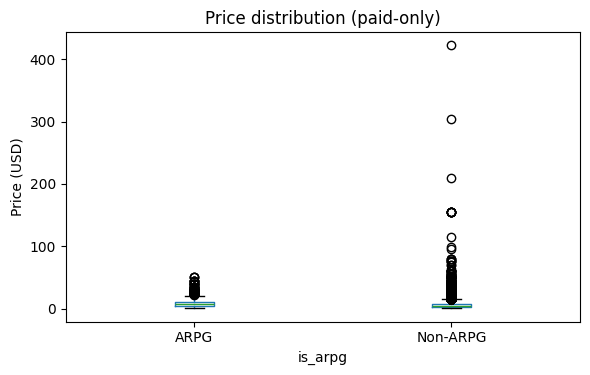

In [8]:
ax = price_paid.replace({True:"ARPG", False:"Non-ARPG"}).boxplot(by="is_arpg", column="price", grid=False, figsize=(6,4))
plt.suptitle("")
plt.title("Price distribution (paid-only)")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.savefig(OUT / "price_arpg_vs_non_paid.png", bbox_inches="tight")


In [9]:
arpg_all  = price_summary_all.get(True,  float("nan"))
non_all   = price_summary_all.get(False, float("nan"))
arpg_paid = price_summary_paid.get(True,  float("nan"))
non_paid  = price_summary_paid.get(False, float("nan"))

say(
    "**Answer:** "
    f"All titles median price — ARPG **{fmt_money(arpg_all)}** vs Non-ARPG **{fmt_money(non_all)}**.  \n"
    f"Paid-only median price — ARPG **{fmt_money(arpg_paid)}** vs Non-ARPG **{fmt_money(non_paid)}**."
)

**Answer:** All titles median price — ARPG **N/A** vs Non-ARPG **N/A**.  
Paid-only median price — ARPG **N/A** vs Non-ARPG **N/A**.

## Q3. Do ARPGs get more positive review share?
We compute % positive = positive_ratings / (positive + negative), then compare medians across ARPG vs Non-ARPG.

In [10]:
rev = steam[["is_arpg","positive_ratings","negative_ratings"]].copy()
rev[["positive_ratings","negative_ratings"]] = rev[["positive_ratings","negative_ratings"]].fillna(0)
rev["total"] = rev["positive_ratings"] + rev["negative_ratings"]
rev = rev.loc[rev["total"] > 0].copy()
rev["pos_rate"] = rev["positive_ratings"] / rev["total"]

med_pos_rate = rev.groupby("is_arpg")["pos_rate"].median().rename({False:"Non-ARPG", True:"ARPG"})
med_pos_rate


is_arpg
Non-ARPG    0.763636
ARPG        0.726673
Name: pos_rate, dtype: float64

In [11]:
say(
    f"**Answer:** Median positive-review share — "
    f"ARPG **{med_pos_rate.get(True, float('nan')):.1%}** vs "
    f"Non-ARPG **{med_pos_rate.get(False, float('nan')):.1%}**."
)


**Answer:** Median positive-review share — ARPG **nan%** vs Non-ARPG **nan%**.

## Q4. How has ARPG release volume changed over time?
We count distinct ARPG titles per release year and plot the last decade.

release_year
2008      5
2009     12
2010     13
2011     17
2012     24
2013     34
2014     98
2015    213
2016    269
2017    394
2018    525
2019    164
Name: appid, dtype: int64

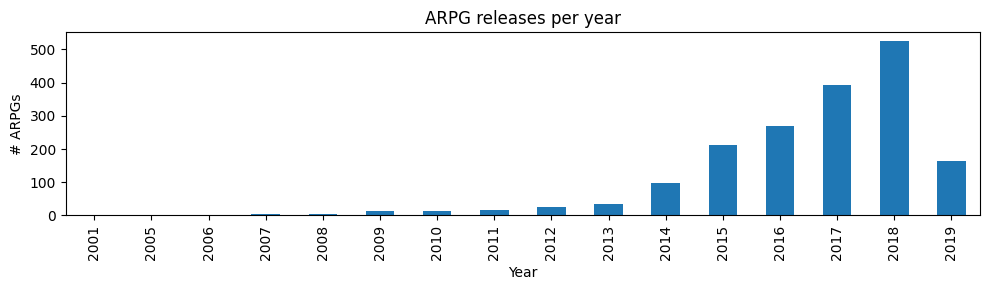

In [12]:
arpg_by_year = (
    steam.loc[steam["is_arpg"] & steam["release_year"].notna()]
         .groupby("release_year")["appid"].nunique()
         .astype(int)
         .sort_index()
)

ax = arpg_by_year.plot(kind="bar", figsize=(10,3), title="ARPG releases per year")
ax.set_xlabel("Year"); ax.set_ylabel("# ARPGs")
plt.tight_layout()
plt.savefig(OUT / "arpg_by_year.png", bbox_inches="tight")

arpg_by_year.tail(12)


In [13]:
if len(arpg_by_year):
    peak_year = int(arpg_by_year.idxmax())
    peak_val  = int(arpg_by_year.max())
    tail_txt  = ", ".join(f"{int(y)}: {int(n)}" for y, n in arpg_by_year.tail(10).items())
else:
    peak_year, peak_val, tail_txt = "N/A", "N/A", "(no data)"

say(
    f"**Answer:** ARPG releases peak in **{peak_year}** with **{peak_val}** titles.  \n"
    f"Recent years (last 10): {tail_txt}.  \n"
    "See the figure saved to `reports/arpg_by_year.png`."
)


**Answer:** ARPG releases peak in **2018** with **525** titles.  
Recent years (last 10): 2010: 13, 2011: 17, 2012: 24, 2013: 34, 2014: 98, 2015: 213, 2016: 269, 2017: 394, 2018: 525, 2019: 164.  
See the figure saved to `reports/arpg_by_year.png`.

## Q5. What tags most often co-occur with ARPGs?
Using the long tag table, we sum tag percentages across ARPG titles and list the top co-tags.

In [14]:
top_arpg_tags = (
    tag_long.merge(steam[["appid","is_arpg"]], on="appid", how="inner")
            .query("is_arpg == True")
            .groupby("tag")["pct"].sum()
            .sort_values(ascending=False)
            .head(15)
)

top_arpg_tags.to_frame("sum_pct")


,sum_pct
tag,
action,122541
rpg,116989
adventure,89003
multiplayer,70531
open_world,69886
indie,69851
survival,59531
co_op,45965
singleplayer,42928


In [15]:
top5 = ", ".join(top_arpg_tags.head(5).index.tolist()) if len(top_arpg_tags) else "N/A"
say(f"**Answer:** Common ARPG co-tags include: **{top5}**.")


**Answer:** Common ARPG co-tags include: **action, rpg, adventure, multiplayer, open_world**.

## Is there a relationship between price and total reviews for ARPGs?
We compute Pearson correlation and show a scatterplot.


0.17598766591384

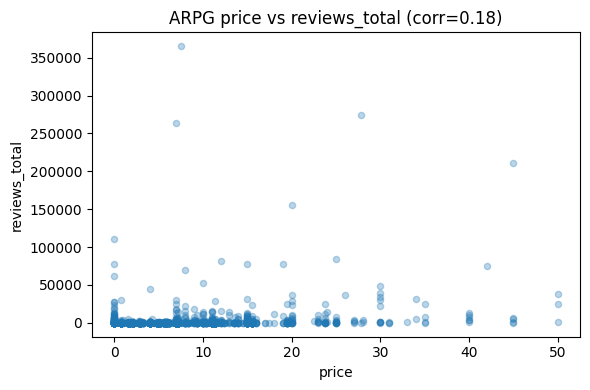

In [16]:
arpg = steam.loc[steam["is_arpg"]].copy()
arpg["reviews_total"] = arpg["reviews_total"].fillna(0)
arpg_plot = arpg.loc[arpg["price"].notna() & arpg["reviews_total"].notna()].copy()

corr = arpg_plot[["price","reviews_total"]].corr().loc["price","reviews_total"]
ax = arpg_plot.plot(kind="scatter", x="price", y="reviews_total", alpha=0.3,
                    title=f"ARPG price vs reviews_total (corr={corr:.2f})", figsize=(6,4))
plt.tight_layout()
plt.savefig(OUT / "arpg_price_vs_reviews.png", bbox_inches="tight")

float(corr)


In [17]:
say(f"**Answer:** Price–reviews correlation for ARPGs is **{corr:.2f}** "
    "(near 0 = weak linear relationship).")


**Answer:** Price–reviews correlation for ARPGs is **0.18** (near 0 = weak linear relationship).